In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os

import gsw
import pyresample
from xgcm import Grid

from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36675/status,
Dashboard: /proxy/36675/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40203,Workers: 7
Dashboard: /proxy/36675/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40863,Total threads: 2
Dashboard: /proxy/37043/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:33413,


In [3]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km= dg.variables["lat_rho"]
lon_rho_4km = dg.variables["lon_rho"]
lat_u_4km= dg.variables["lat_u"]
lon_u_4km = dg.variables["lon_u"]
lat_v_4km= dg.variables["lat_v"]
lon_v_4km = dg.variables["lon_v"]
cor_4km = dg.variables["f"]
pm_4km = dg.variables["pm"]
pn_4km = dg.variables["pn"]
zice_4km = dg.variables["zice"]
h_4km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)

Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)


In [4]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

In [5]:
%%time
path_ECCO2_4km = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_00*.nc'

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
# ds = xr.open_mfdataset(path_ECCO2_4km + "ocean_avg_00*.nc")
temp_4km= ds.variables["temp"]
salt_4km= ds.variables["salt"]
zeta_4km= ds.variables["zeta"]
melt_4km= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_4km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_4km = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 535 ms, sys: 122 ms, total: 656 ms
Wall time: 983 ms


In [6]:
%%time
ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-10yr_notides/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
# ds = xr.open_mfdataset(path_ECCO2_4km + "ocean_avg_00*.nc")
temp_4kmNT= ds.variables["temp"]
salt_4kmNT= ds.variables["salt"]
zeta_4kmNT= ds.variables["zeta"]
melt_4kmNT= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_4kmNT = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_4kmNT = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 175 ms, sys: 40.6 ms, total: 216 ms
Wall time: 357 ms


In [7]:
%%time

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0020.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
# ds = xr.open_mfdataset(path_ECCO2_4km + "ocean_avg_00*.nc")
temp_10km= ds.variables["temp"]
salt_10km= ds.variables["salt"]
zeta_10km= ds.variables["zeta"]
melt_10km= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10km = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 201 ms, sys: 62 ms, total: 263 ms
Wall time: 569 ms


In [8]:
temp_10km

<xarray.Variable (ocean_time: 12, s_rho: 31, eta_rho: 560, xi_rho: 630)>
dask.array<open_dataset-temp, shape=(12, 31, 560, 630), dtype=float32, chunksize=(1, 11, 187, 210), chunktype=numpy.ndarray>
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

In [9]:
mask_zice_4km = ma.masked_where(zice_4km < 0, np.ones(zice_4km.shape))
mask_outice_4km = ma.masked_where(zice_4km >= 0, np.ones(zice_4km.shape))
mask_shelf_4km = ma.masked_where(h_4km > 2000, np.ones(zice_4km.shape))
mask_outshelf_4km = ma.masked_where(h_4km <= 2000, np.ones(zice_4km.shape))

mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))
mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))


In [10]:
# ----------------------------------------------------------------------------------------------------------------
# load 1500 and calving front contours:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

expt = 'WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_4km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_4km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_4km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_4km_CF = ds.variables["two"]
ds.close()


In [11]:
fig_path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Maps_validations/'


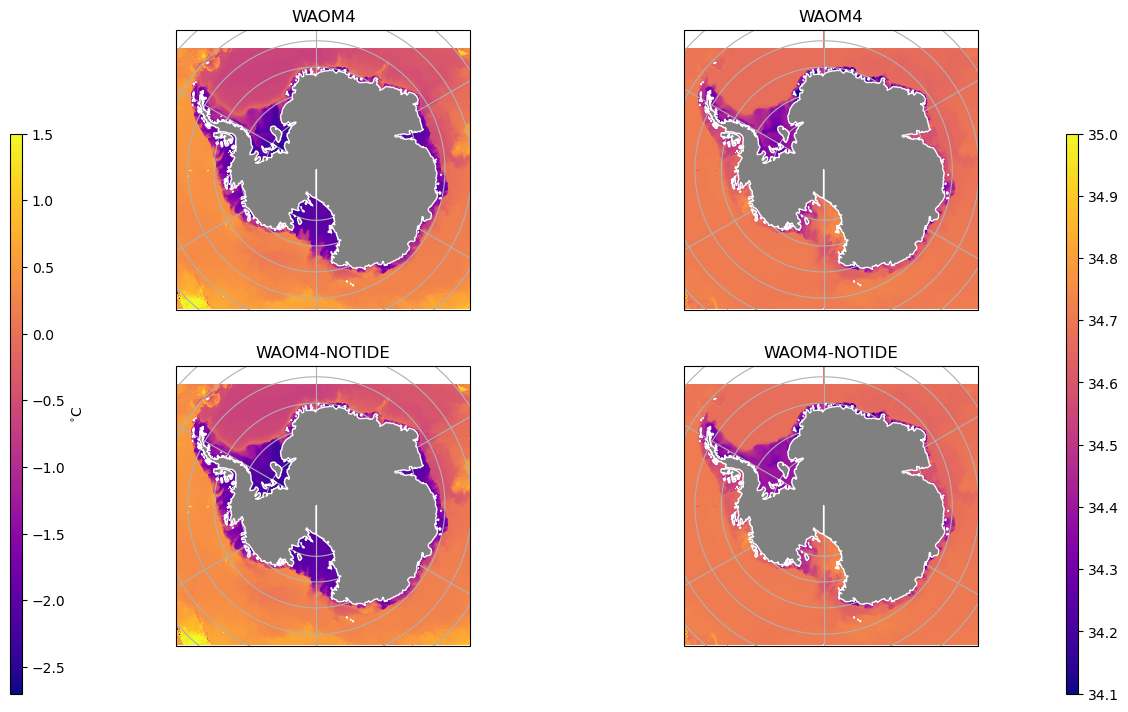

In [12]:
# call cartopy projection
proj = ccrs.SouthPolarStereo()

# ========== subregions plots:
# for 2000m isoline
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
# limits for contour of ice front (Ronne-Filchner IS):
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(100,300,1)

# --- bottom

tmin = -2.7
tmax = 1.5
smin = 34.1
smax = 35.

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4km.isel(s_rho=0).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM4')
ax1.gridlines() # draw_labels=True,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(222, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4km.isel(s_rho=0).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM4')
ax2.gridlines()
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax7 = fig.add_subplot(223, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4kmNT.isel(s_rho=0).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=tmin, vmax=tmax)
# plt.title('Bottom temperature \n WAOM10')
plt.title('WAOM4-NOTIDE')
ax7.gridlines() # draw_labels=True,linewidth=
# ax1.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree())
ratio = .9
ax7.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(224, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4kmNT.isel(s_rho=0).mean('ocean_time')*mask_shelf_4km*mask_zice_4km, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=smin, vmax=smax)
# plt.title('Bottom salinity \n WAOM10')
plt.title('WAOM4-NOTIDE')
ax4.gridlines()
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax3 = fig.add_axes([0.04, 0.05, 0.01, 0.7])
fig.colorbar(ct1, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax4 = fig.add_axes([0.92, 0.05, 0.01, 0.7])
fig.colorbar(cs1, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_xlabel('')#, labelpad=-35)

name_fig='waom4x4-NOTIDE_bottomTSmaps_yr10.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)


In [13]:
%%time

temp_4km.load()

2024-02-16 15:17:51,975 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.35 GiB -- Worker memory limit: 9.00 GiB
2024-02-16 15:18:02,110 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.92 GiB -- Worker memory limit: 9.00 GiB


CPU times: user 11.5 s, sys: 1min 26s, total: 1min 37s
Wall time: 3min 45s


<xarray.Variable (ocean_time: 12, s_rho: 31, eta_rho: 1400, xi_rho: 1575)>
array([[[[ 0.94032705,  1.0196253 ,  0.99296844, ...,  0.9305212 ,
           0.9252657 ,  0.9257791 ],
         [ 0.86102873,  0.9312915 ,  0.90740937, ...,  0.9346377 ,
           0.92955816,  0.9262925 ],
         [ 0.85371023,  0.82763255,  0.84571993, ...,  0.93403816,
           0.9321882 ,  0.93075746],
         ...,
         [ 0.9028317 ,  0.5244774 ,  0.5409816 , ...,  0.3261412 ,
           0.31927866,  0.32201126],
         [ 1.1972436 ,  0.4759557 ,  0.51598805, ...,  0.34367397,
           0.33171448,  0.33346668],
         [ 0.8512985 ,  0.50535345,  0.47404405, ...,  0.45339045,
           0.4063665 ,  0.3699166 ]],

        [[ 0.9489508 ,  1.018655  ,  0.9734049 , ...,  0.9328441 ,
           0.92662364,  0.9270634 ],
         [ 0.8792467 ,  0.9452613 ,  0.91476136, ...,  0.93946534,
           0.93126446,  0.92750317],
         [ 0.8792767 ,  0.8382437 ,  0.8620513 , ...,  0.9377169 ,
           0.9361119 ,  0.93280256],
...
         [ 3.3414016 ,  3.024223  ,  2.839876  , ...,  3.7243552 ,
           3.8204374 ,  3.7746198 ],
         [ 3.1667697 ,  2.951049  ,  2.813718  , ...,  3.8150017 ,
           3.8726926 ,  3.7796628 ],
         [ 3.209243  ,  3.2517166 ,  3.026606  , ...,  3.716796  ,
           3.7447512 ,  3.762207  ]],

        [[ 7.5845838 ,  7.9012165 ,  7.739644  , ...,  7.0980434 ,
           7.0632567 ,  7.1005025 ],
         [ 7.267951  ,  7.895763  ,  7.597009  , ...,  7.257861  ,
           7.334862  ,  7.137748  ],
         [ 7.2902837 ,  7.828432  ,  7.5192986 , ...,  7.123468  ,
           7.2703605 ,  7.176919  ],
         ...,
         [ 3.252383  ,  3.0731144 ,  2.9215832 , ...,  3.852764  ,
           3.8732395 ,  4.159073  ],
         [ 3.122086  ,  3.0180216 ,  2.8990932 , ...,  4.008701  ,
           4.0005407 ,  4.2967114 ],
         [ 3.2179472 ,  3.3138084 ,  3.1000817 , ...,  4.2243943 ,
           4.16118   ,  4.2289457 ]]]], dtype=float32)
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

<xarray.Variable ()>
array(-179.96177731)
<xarray.Variable ()>
array(179.96177731)


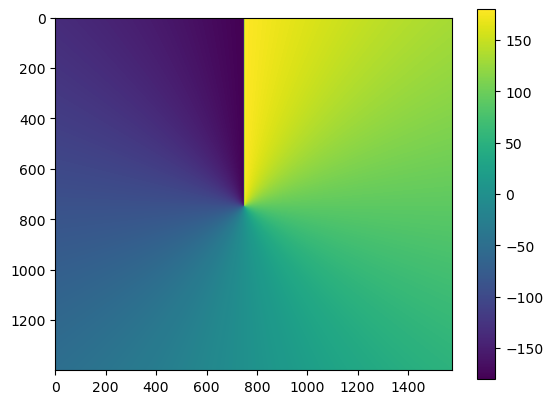

In [14]:
plt.imshow(lon_rho_4km)
plt.colorbar()

print(lon_rho_4km.min())
print(lon_rho_4km.max())

(900, 400)
(1400, 1575)


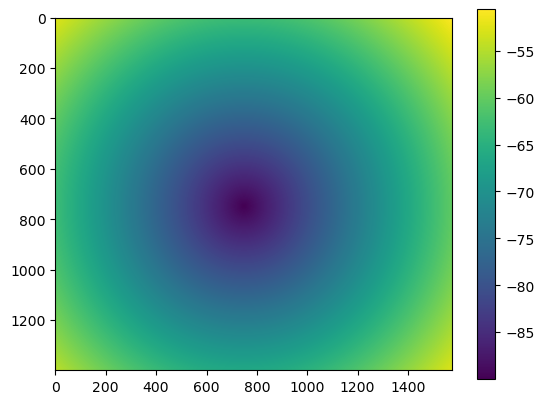

In [15]:
plt.imshow(lat_rho_4km)
plt.colorbar()

print(lon_rho_4km[500:,600:1000].shape)
print(lat_rho_4km.shape)

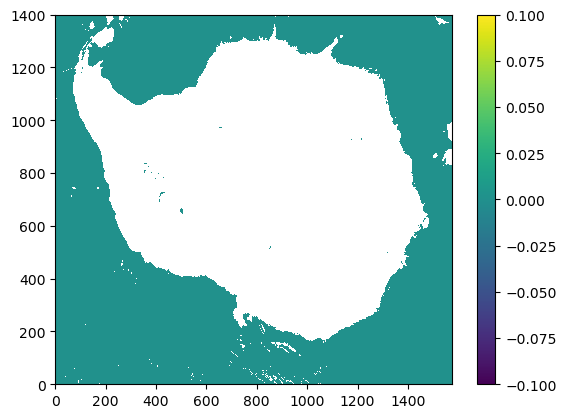

In [17]:
plt.pcolormesh(mask_outshelf_4km*np.zeros(mask_outshelf_4km.shape))
plt.colorbar()

In [29]:
100/2.5

40.0

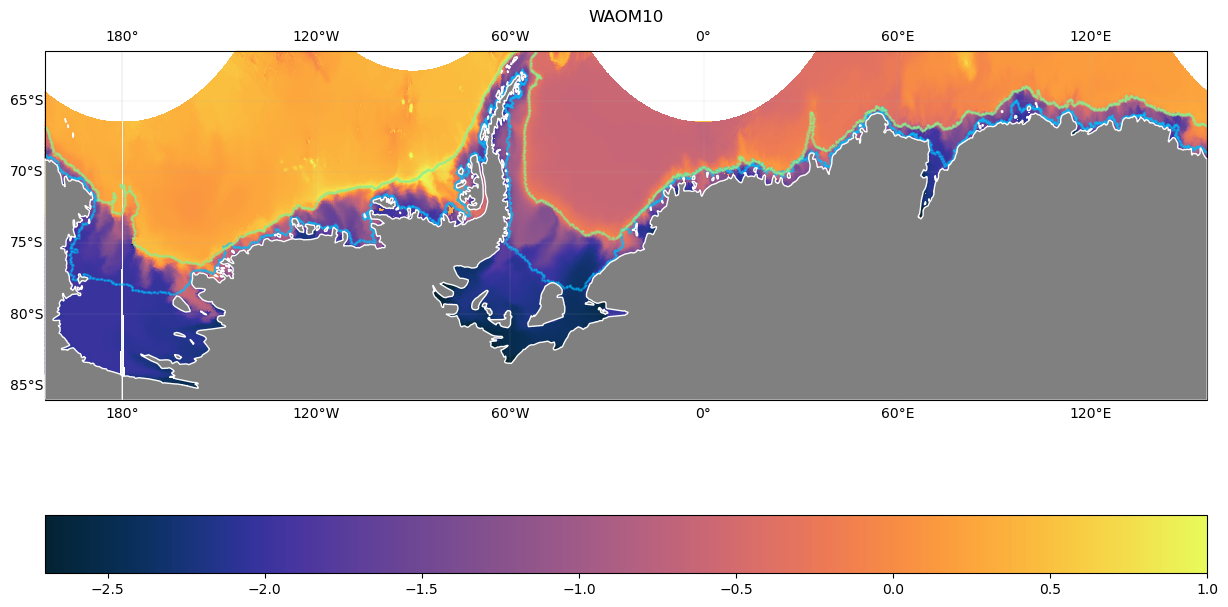

In [33]:
# Fig 1 - paper (WAOM10)
# --- bottom T
temp10km_shelf_annual = temp_10km.isel(s_rho=0).mean('ocean_time')

jst= 41
jen=-1
ist=0 #600
ien=-1 #000

tmin = -2.7
tmax = 1

# call cartopy projection
# proj = ccrs.SouthPolarStereo()
proj = ccrs.PlateCarree(central_longitude=-24)
# proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=0.0, false_easting=0.0, false_northing=0.0, globe=None)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(111, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,temp10km_shelf_annual[jst:jen,ist:ien], transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax) #lev=np.arange(-2.7,1,0.5),

plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
plt.colorbar(ct1, location="bottom")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

name_fig='waom10extend_bottomTmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


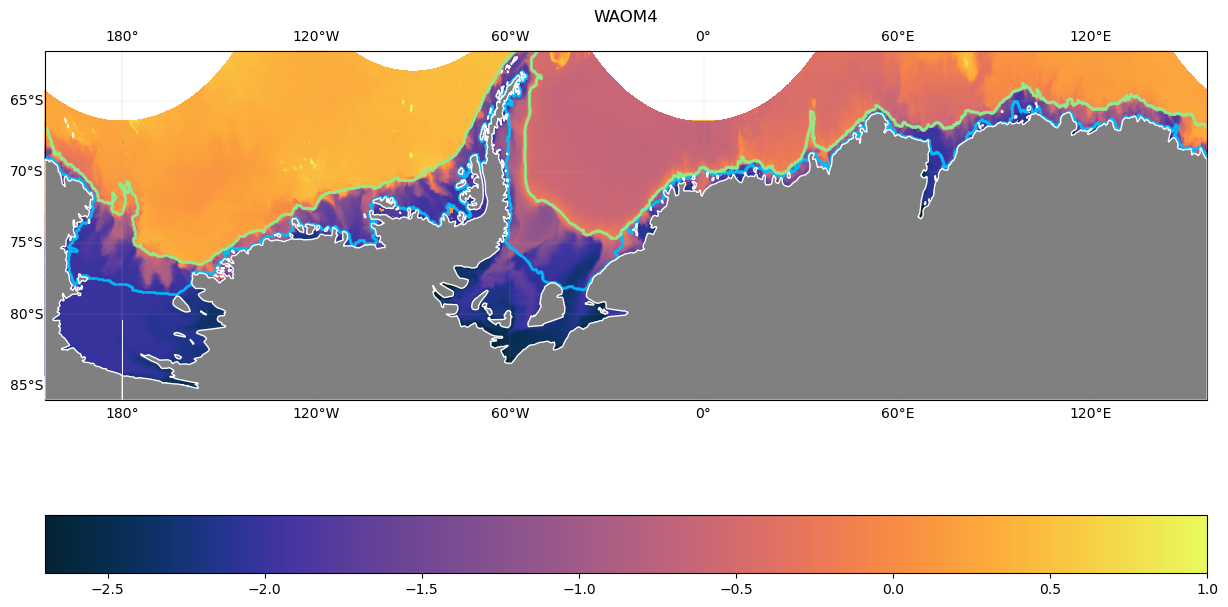

In [19]:
# Fig 1 - paper (WAOM4)
# --- bottom T
temp4km_shelf_annual = temp_4km.isel(s_rho=0).mean('ocean_time')

jst= 100
jen=-1
ist=0 #600
ien=-1 #000

tmin = -2.7
tmax = 1

# call cartopy projection
# proj = ccrs.SouthPolarStereo()
proj = ccrs.PlateCarree(central_longitude=-24)
# proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=0.0, false_easting=0.0, false_northing=0.0, globe=None)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(111, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp4km_shelf_annual[jst:jen,ist:ien], transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax) #lev=np.arange(-2.7,1,0.5),

plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
plt.colorbar(ct1, location="bottom")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

name_fig='waom4extend_bottomTmaps_yr10_PlateCarree.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


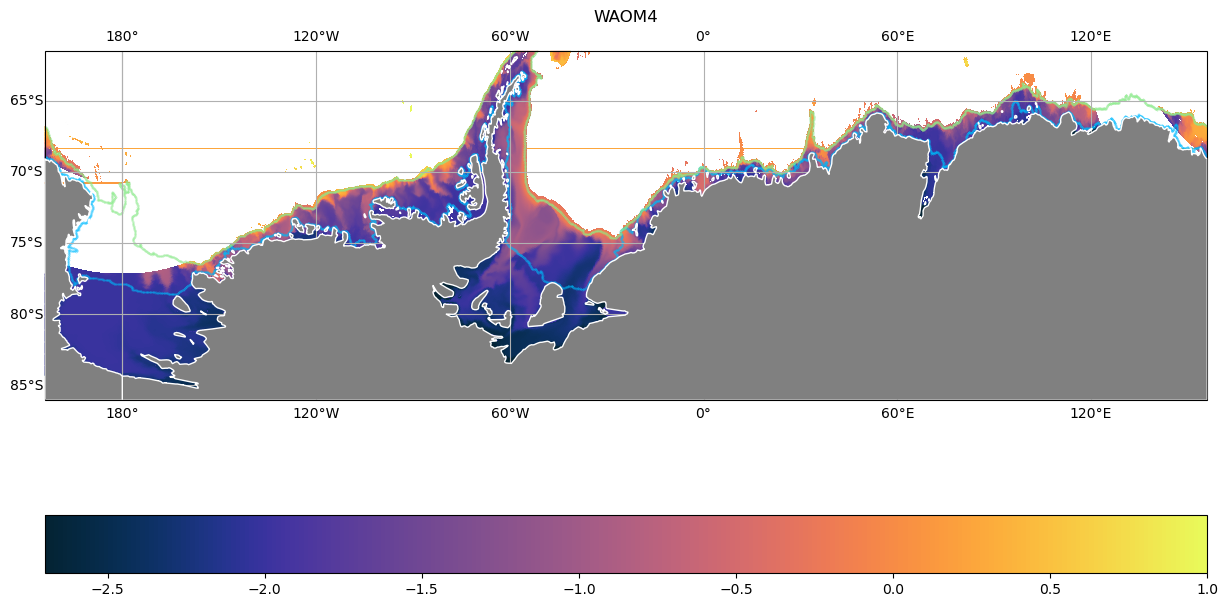

In [32]:

# call cartopy projection
# proj = ccrs.SouthPolarStereo()
proj = ccrs.PlateCarree(central_longitude=-24.0)
# proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=0.0, false_easting=0.0, false_northing=0.0, globe=None)


fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(111, projection=proj)
# plot by pieces to avoid extrapolation error:
jst= 400
jen=-1
ist=0 #600
ien=-1 #000
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp4km_shelf_annual[jst:jen,ist:ien].values*mask_shelf_4km[jst:jen,ist:ien], transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax) #lev=np.arange(-2.7,1,0.5),
j1=155
j2=200
ct1=plt.pcolormesh(lon_rho_4km[j1:j2,:],lat_rho_4km[j1:j2,:],temp4km_shelf_annual[j1:j2,:].values*mask_shelf_4km[j1:j2,:], transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \
j1=201
j2=224
ct1=plt.pcolormesh(lon_rho_4km[j1:j2,:],lat_rho_4km[j1:j2,:],temp4km_shelf_annual[j1:j2,:].values*mask_shelf_4km[j1:j2,:], transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \

plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=.1, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')

ax1.gridlines(draw_labels=True)#,linewidth=
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
plt.colorbar(ct1, location="bottom")
ax1.set_extent([-180, 180, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


name_fig='waom4extend_bottomTmaps_yr10_PlateCarree_shelf.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


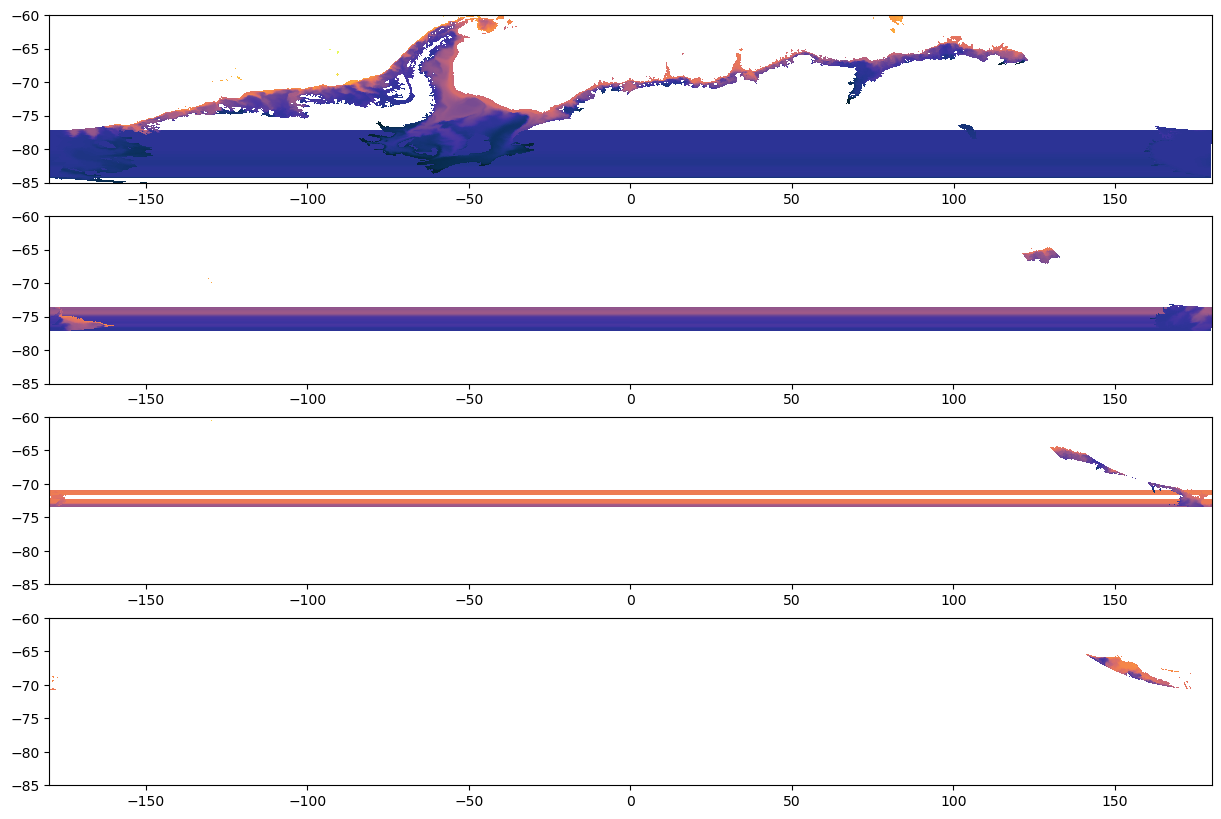

In [16]:
# TESTING WITHOUT CARTOPY

temp4km_shelf_annual = temp_4km.isel(s_rho=0).mean('ocean_time')


fig = plt.figure(figsize=(15,10))


jst= 400
jen=-1
ist=0 #600
ien=-1 #000
ax1 = fig.add_subplot(411) # yes plot, all clear
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien],lat_rho_4km[jst:jen,ist:ien],temp4km_shelf_annual[jst:jen,ist:ien].values*mask_shelf_4km[jst:jen,ist:ien], cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \
ax1.set_ylim(-85,-60)

ax2 = fig.add_subplot(412)
j1=300
j2=400
ct1=plt.pcolormesh(lon_rho_4km[j1:j2,:],lat_rho_4km[j1:j2,:],temp4km_shelf_annual[j1:j2,:]*mask_shelf_4km[j1:j2,:], cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \
ax2.set_ylim(-85,-60)

ax3 = fig.add_subplot(413)
j1=225
j2=299
ct1=plt.pcolormesh(lon_rho_4km[j1:j2,:],lat_rho_4km[j1:j2,:],temp4km_shelf_annual[j1:j2,:]*mask_shelf_4km[j1:j2,:], cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \
ax3.set_ylim(-85,-60)

ax4 = fig.add_subplot(414) # yes plot, one line to be removed.
j1=155
j2=224
ct1=plt.pcolormesh(lon_rho_4km[j1:j2,:],lat_rho_4km[j1:j2,:],temp4km_shelf_annual[j1:j2,:]*mask_shelf_4km[j1:j2,:], cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)#, \
ax4.set_ylim(-85,-60)


plt.show()

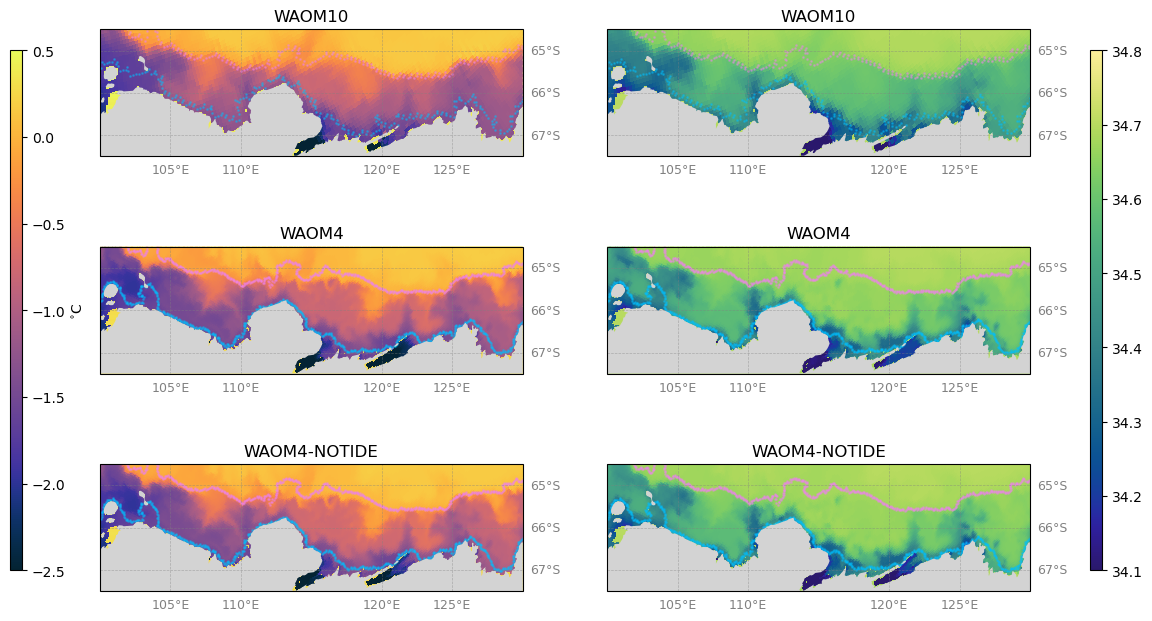

In [21]:
# --------------------------------------------------------------------------
# zoomm near TIS/MUIS

# --- bottom

tmin = -2.5
tmax = .5
smin = 34.1
smax = 34.8

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=115.0)
ratio = .3

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax1.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax2 = fig.add_subplot(322, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax2.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax3.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax4 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax4.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax5 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4kmNT.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax5.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax6 = fig.add_subplot(326, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4kmNT.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax6.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.05, 0.17, 0.01, 0.65])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax2 = fig.add_axes([0.95, 0.17, 0.01, 0.65])
fig.colorbar(cs1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4x4-NOTIDE_bottomTSmaps_yr10_EAntTIS.png'
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()

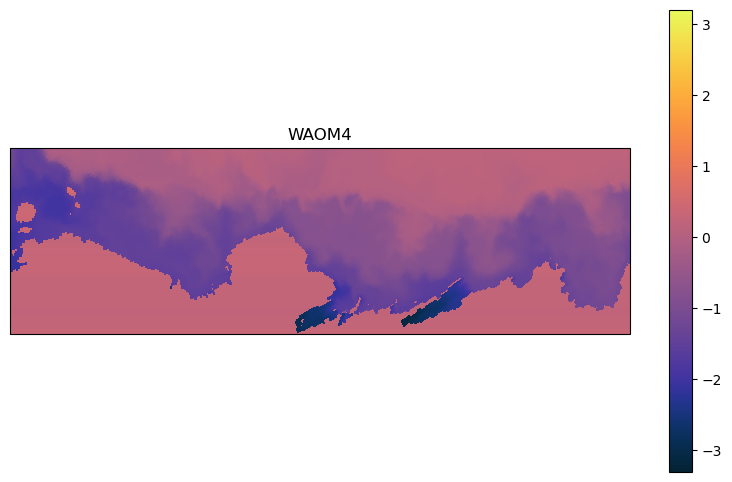

In [22]:
fig = plt.figure(figsize=(10,6))

proj = ccrs.PlateCarree(central_longitude=115.0)
ratio = .3
ax = fig.add_subplot(111, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal)#, vminmin, vmax=smax)
plt.colorbar()
ax.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
plt.title('WAOM4')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

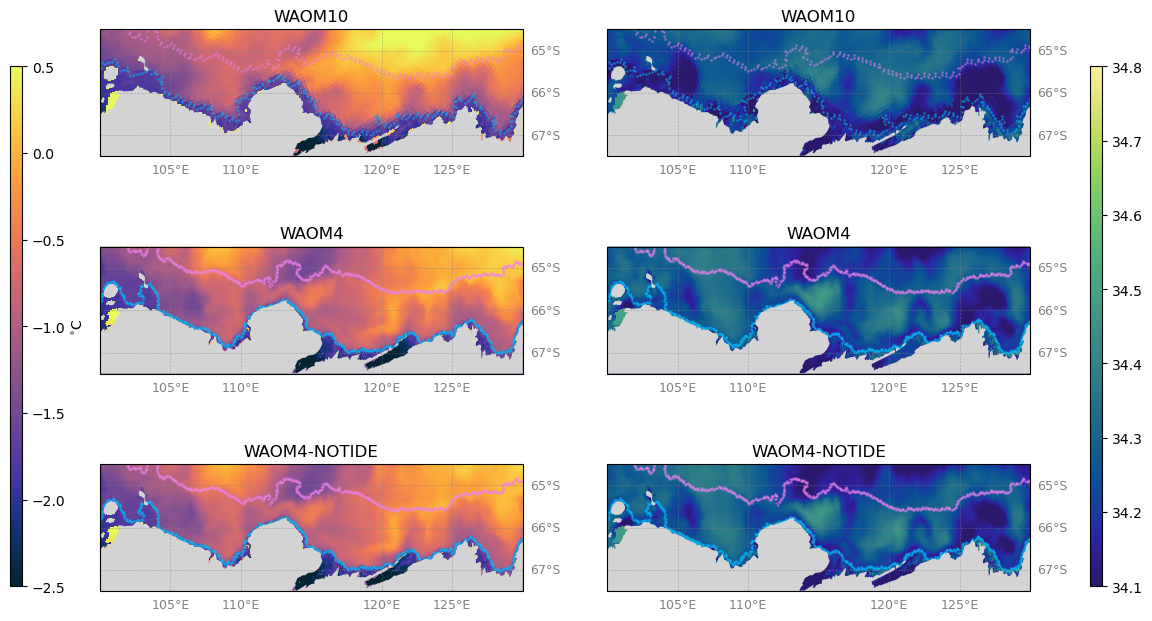

In [23]:
# --------------------------------------------------------------------------
# zoomm near TIS/MUIS

# --- bottom

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=115.0)
ratio = .3

ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax1.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax2 = fig.add_subplot(322, projection=proj)
cs1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,salt_10km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax2.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax3.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax4 = fig.add_subplot(324, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4km.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax4.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax5 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4kmNT.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax5.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax6 = fig.add_subplot(326, projection=proj)
cs1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,salt_4kmNT.isel(s_rho=-1).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline, vmin=smin, vmax=smax)
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=1, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_shelf,lat_along_4km_shelf, s=1, alpha=0.4, color='violet',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4-NOTIDE')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([105, 110, 120, 125])
gl.ylocator = mticker.FixedLocator([-65, -66, -67])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}
ax6.set_extent([100, 130, -64.5, -67.5], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray') #edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.65])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('$^{\circ}$C')#, labelpad=-35)

cbar_ax2 = fig.add_axes([0.95, 0.15, 0.01, 0.65])
fig.colorbar(cs1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('')#, labelpad=-35)

name_fig='waom10x4x4-NOTIDE_sfcTSmaps_yr10_EAntTIS.png'
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()

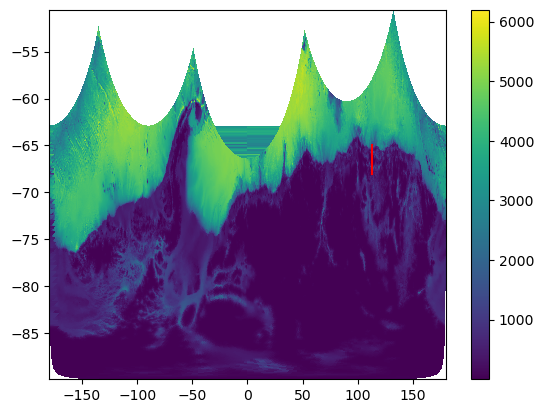

In [24]:
## transecto at 113.5E (Pena-Molino et al 2016)

# ct1=plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_10km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
# ct1=plt.pcolormesh(lon_rho_4km,lat_rho_4km,temp_4km.isel(s_rho=0).mean('ocean_time'), transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)


plt.pcolormesh(lon_rho_10km,lat_rho_10km,h_10km)
plt.colorbar()
plt.plot([113,113],[-68,-65],'r')


(150.0, 250.0)

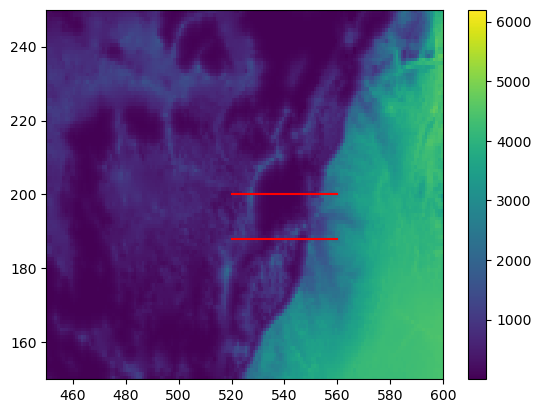

In [25]:
xi_ind = [520,560]
eta_ind = [188,188]

xi_ind2 = [520,560]
eta_ind2 = [200,200]

plt.pcolormesh(h_10km)
plt.colorbar()
plt.plot(xi_ind,eta_ind,'r')
plt.plot(xi_ind2,eta_ind2,'r')
plt.xlim(450,600)
plt.ylim(150,250)

In [26]:
#WAOM10, TIS transect: 115E
minxi = 520
maxxi = 560
eta = 188

lonstr10 = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp10 = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp10[kk,:] = lattmp
depp10 = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp10 = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp10 = salt_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp10.shape, depp10.transpose().shape, tempp10.shape)

#WAOM4: x2.5 10km
minxi = 1300
maxxi = 1400
eta = 470
lonstr4 = "%.3f" % lon_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp4 = np.empty(temp_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp4[kk,:] = lattmp
depp4 = z_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4 = temp_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4 = salt_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp4.shape, depp4.transpose().shape, tempp4.shape)

#WAOM4-NOTIDE:
depp4NT = z_rho_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4NT = temp_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4NT = salt_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')

# plt.pcolormesh(latp10,depp10.transpose().fillna(0),tempp10)
# plt.colorbar()
# plt.ylim(-2300,10)
# plt.text(-66.5,-2000,lonstr10 + "$^{\circ}$E")

(31, 40) (31, 40) (31, 40)
(31, 100) (31, 100) (31, 100)


In [27]:
#WAOM10, TIS transect: 120E
minxi = 510
maxxi = 560
eta = 162

lonstr10b = "%.3f" % lon_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp10b = np.empty(temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp10b[kk,:] = lattmp
depp10b = z_rho_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp10b = temp_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp10b = salt_10km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp10.shape, depp10.transpose().shape, tempp10.shape)

#WAOM4:
minxi = 1275
maxxi = 1400
eta = 405
lonstr4b = "%.3f" % lon_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('xi_rho').to_numpy()
latp4b = np.empty(temp_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time').shape)
lattmp = lat_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta)
for kk in range(0,31):
    latp4b[kk,:] = lattmp
depp4b = z_rho_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4b = temp_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4b = salt_4km.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
print(latp4.shape, depp4.transpose().shape, tempp4.shape)

#WAOM4-NOTIDE:
depp4NTb = z_rho_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
tempp4NTb = temp_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')
saltp4NTb = salt_4kmNT.isel(xi_rho=slice(minxi,maxxi),eta_rho=eta).mean('ocean_time')



(31, 40) (31, 40) (31, 40)
(31, 100) (31, 100) (31, 100)


2024-02-08 15:48:38,501 - distributed.worker.memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 3.92 GiB -- Worker memory limit: 4.50 GiB
2024-02-08 15:48:39,117 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:34943 (pid=345420) exceeded 95% memory budget. Restarting...
2024-02-08 15:48:39,221 - distributed.nanny - WARNING - Restarting worker
2024-02-08 15:48:42,016 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:35969 (pid=345417) exceeded 95% memory budget. Restarting...
2024-02-08 15:48:42,050 - distributed.nanny - WARNING - Restarting worker
2024-02-08 15:48:49,618 - distributed.worker.memory - WARNING - Worker is at 88% memory usage. Pausing worker.  Process memory: 3.99 GiB -- Worker memory limit: 4.50 GiB
2024-02-08 15:48:50,315 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:46231 (pid=346116) exceeded 95% memory budget. Restarting...
2024-02-08 15:48:50,444 - distributed.nanny - WARNING - Restarting work

KilledWorker: Attempted to run task ('add-getitem-mean_agg-aggregate-mean_chunk-where-6d232f181bfda3cecfcb36220cbda337', 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:44137. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

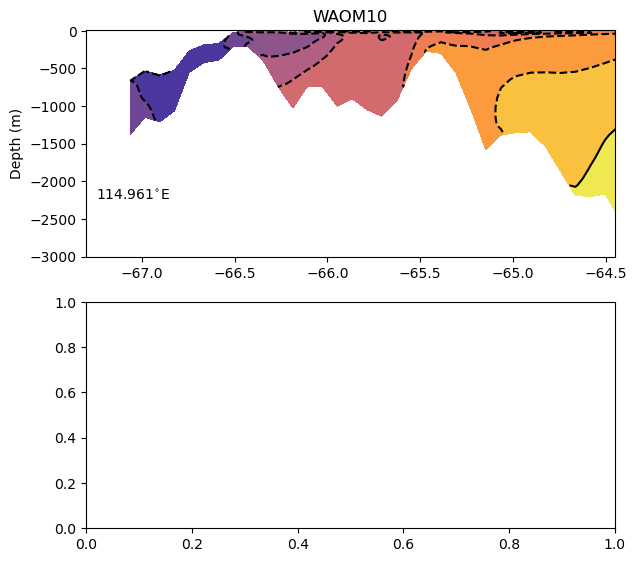

In [21]:
import cmocean

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(321)
cc = plt.contourf(latp10,depp10.transpose().fillna(0),tempp10,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp10,depp10.transpose().fillna(0),tempp10,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp10,depp10.transpose().fillna(0),tempp10, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax1.set_ylim(-3000,10)
ax1.set_xlim(-67.3,-64.45)
plt.text(-67.25,-2250,lonstr10 + "$^{\circ}$E")
ax1.set_title('WAOM10')
ax1.set_ylabel('Depth (m)')

ax2 = fig.add_subplot(323)
cc = plt.contourf(latp4,depp4.transpose().fillna(0),tempp4,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4,depp4.transpose().fillna(0),tempp4,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4,depp4.transpose().fillna(0),tempp4, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax2.set_ylim(-3000,10)
ax2.set_xlim(-67.3,-64.45)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax2.set_title('WAOM4')
ax2.set_ylabel('Depth (m)')

ax3 = fig.add_subplot(325)
cc = plt.contourf(latp4,depp4NT.transpose().fillna(0),tempp4NT,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4,depp4NT.transpose().fillna(0),tempp4NT,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4,depp4.transpose().fillna(0),tempp4, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax3.set_ylim(-3000,10)
ax3.set_xlim(-67.3,-64.45)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax3.set_title('WAOM4-NOTIDES')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth (m)')

ax1 = fig.add_subplot(322)
cc = plt.contourf(latp10b,depp10b.transpose().fillna(0),tempp10b,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp10b,depp10b.transpose().fillna(0),tempp10b,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp10b,depp10b.transpose().fillna(0),tempp10b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax1.set_ylim(-3000,10)
# ax1.set_xlim(-66.85,-65.4)
plt.text(-67,-2250,lonstr10b + "$^{\circ}$E")
ax1.set_title('WAOM10')
# ax1.set_ylabel('Depth (m)')

ax2 = fig.add_subplot(324)
cc = plt.contourf(latp4b,depp4b.transpose().fillna(0),tempp4b,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4b,depp4b.transpose().fillna(0),tempp4b,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4b,depp4b.transpose().fillna(0),tempp4b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax2.set_ylim(-3000,10)
# ax2.set_xlim(-66.85,-65.4)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax2.set_title('WAOM4')
# ax2.set_ylabel('Depth (m)')

ax3 = fig.add_subplot(326)
cc = plt.contourf(latp4b,depp4NTb.transpose().fillna(0),tempp4NTb,np.arange(-2.5,.5,.25), cmap=cmocean.cm.thermal)
plt.contour(latp4b,depp4NTb.transpose().fillna(0),tempp4NTb,np.arange(-2.5,.5,.25),colors='black')
# plt.pcolormesh(latp4b,depp4NTb.transpose().fillna(0),tempp4b, vmin=tmin, vmax=tmax)
# plt.colorbar()
ax3.set_ylim(-3000,10)
# ax3.set_xlim(-66.85,-65.4)
# plt.text(-67,-2400,lonstr4 + "$^{\circ}$E")
ax3.set_title('WAOM4-NOTIDES')
ax3.set_xlabel('Latitude')
# ax3.set_ylabel('Depth (m)')

cbar_ax1 = fig.add_axes([0.92, 0.11, 0.01, 0.76])
fig.colorbar(cc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Temperature ($^{\circ}$C)')#, labelpad=-35)

# plt.show()
name_fig='waom10x4x4-NOTIDE_Tcross_yr10_EAntTIS.png'
plt.savefig(fig_path + name_fig, dpi=300)


In [ ]:
# plot TS-diag just for the transects:

In [76]:
# make grid for density contours
smin = 30 - (0.01 * 30)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -4. + (0.1 * -4.)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 5 + (0.1 * 5.)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-4,5,ydim)
si = np.linspace(30,36,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],2000) # sigma-2000
# Substract 1000 to convert to sigma-2
dens = dens - 1000

tmin, tmax, smin, smax sizes=, -4.4 5.5 29.7 36.36


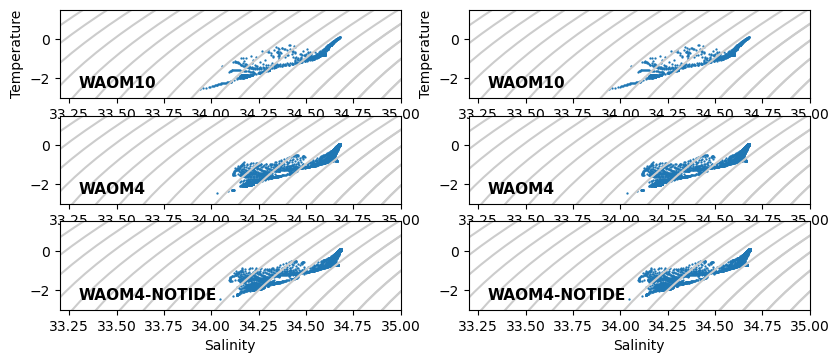

In [84]:
import cmocean

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15, 5))
# normal isopycnals
for bb in range(0,3):
    for aa in range(0,2):
        CS1 = ax[bb,aa].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        # ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
        CS2 = ax[bb,aa].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
        # ax[bb,aa].clabel(CS2, CS2.levels, inline=True, fontsize=10)
        ax[bb,aa].set_xlim([33.2,35])
        ax[bb,aa].set_ylim([-3,1.5])
        ax[0,aa].set_ylabel('Temperature')
        ax[bb,aa].set_xlabel('Salinity')# East antarct.
            
sc = ax[0,0].scatter(saltp10,tempp10, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,0].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1,0].scatter(saltp4,tempp4, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,0].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2,0].scatter(saltp4NT,tempp4NT, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,0].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

sc = ax[0,1].scatter(saltp10,tempp10, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0,1].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1,1].scatter(saltp4,tempp4, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1,1].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2,1].scatter(saltp4NT,tempp4NT, marker="p", s=(72./fig.dpi)**2, label='Annual avg')#, cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2,1].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')



# - cbar horiz
# cbar_ax1 = fig.add_axes([0.25, 0.2, 0.5, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_Tcross_yr10_EAntTIS.png"
plt.savefig(name_fig, dpi=300)